---
# Origin US file
---

Use `analysis-rachael/env/monte_carlo.yaml` to create an environment for this notebook:
```
 conda env create -f [analysis-rachael/env/monte_carlo.yaml]
```
or, to activate this environment, use
```
 conda activate monte_carlo
```
To deactivate an active environment, use
```
 conda deactivate
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml

In [2]:
# User inputs
file_dir  = '/Users/rmueller/Data/MIDOSS/DeptOfEcology/'
file_name = 'MuellerTrans4-30-20.xlsx'

# This is the precision used to calculate oil type weights 
# Trial and error showed that a precision of 2 is neccessary for weights
# to sum to 1.0
precision = 2

# The following list includes facilities used in Casey's origin/destination analysis 
# with names matching the Dept. of Ecology (DOE) database.  
# For example, the shapefile "Maxum Petroleum - Harbor Island Terminal" is labeled as 'Maxum (Rainer Petroleum)'
# in the DOE database.  I use the Ecology language here and will need to translate to Shapefile speak 
facility_names = [ 'BP Cherry Point Refinery', 'Shell Puget Sound Refinery', 'Shell Oil LP Seattle Distribution Terminal',
                   'Maxum (Rainer Petroleum)', 'Tidewater Snake River Terminal','Nustar Energy Tacoma', 
                   'SeaPort Sound Terminal', 'Tesoro Vancouver Terminal','Phillips 66 Ferndale Refinery', 
                   'Phillips 66 Tacoma Terminal', 'Andeavor Anacortes Refinery (formerly Tesoro)',
                   'Tesoro Port Angeles Terminal','U.S. Oil & Refining','Naval Air Station Whidbey Island (NASWI)',
                   'NAVSUP Manchester', 'Alon Asphalt Company (Paramount Petroleum)', 'Kinder Morgan Liquids Terminal - Harbor Island',
                   'Nustar Energy Tacoma', 'Tesoro Pasco Terminal', 'REG Grays Harbor, LLC', 'Tidewater Vancouver Terminal',
                   'TLP Management Services LLC (TMS)']

# define vessel and oil types to include in .yaml file
vessel_types = ['atb', 'barge', 'tanker']
oil_types    = ['akns', 'bunker', 'dilbit', 'jet', 'diesel', 'gas', 'other']
data_types    = ['total_gallons', 'fraction_of_total', 'number_of_transfers']

In [3]:
# Import columns are: (G) Deliverer, (H) Receiver, (O) Region, (P) Product, 
#                     (Q) Quantity in Gallons, (R) Transfer Type (oiling, Cargo, or Other)', 
#                     (w) DelivererTypeDescription, (x) ReceiverTypeDescription 
df = pd.read_excel(f'{file_dir}{file_name}',sheet_name='Vessel Oil Transfer', 
                   usecols="G,H,P,Q,R,W,X")

df.TransferQtyInGallon = df.TransferQtyInGallon.astype(float).round(precision)

# housekeeping
df['Receiver'] = df['Receiver'].str.replace('US Oil Tacoma ', 'U.S. Oil & Refining')
df['Receiver'] = df['Receiver'].str.replace('TLP', 'TLP Management Services LLC (TMS)')
df['Deliverer'] = df['Deliverer'].str.replace('US Oil Tacoma ', 'U.S. Oil & Refining')
df['Deliverer'] = df['Deliverer'].str.replace('TLP', 'TLP Management Services LLC (TMS)')

## Create name lists for the DOE oil types used in our monte-carlo oil categories

In [4]:
# identify all names of oils in DOE database that are attributed to our oil types
oil_classification = {}
for oil in oil_types:
    oil_classification[oil] = []

[nrows,ncols] = df.shape
for row in range(nrows):
    if 'CRUDE' in df.Product[row] and df.Product[row] not in oil_classification['akns']:
        oil_classification['akns'].append(df.Product[row])
    elif 'BAKKEN' in df.Product[row] and df.Product[row] not in oil_classification['akns']:
        oil_classification['akns'].append(df.Product[row])
    elif 'BUNKER' in df.Product[row] and df.Product[row] not in oil_classification['bunker']:
        oil_classification['bunker'].append(df.Product[row])
    elif 'BITUMEN' in df.Product[row] and df.Product[row] not in oil_classification['dilbit']:
        oil_classification['dilbit'].append(df.Product[row])
    elif 'DIESEL' in df.Product[row] and df.Product[row] not in oil_classification['diesel']:
        oil_classification['diesel'].append(df.Product[row])
    elif 'GASOLINE' in df.Product[row] and df.Product[row] not in oil_classification['gas']:
        oil_classification['gas'].append(df.Product[row])
    elif 'JET' in df.Product[row] and df.Product[row] not in oil_classification['jet']:
        oil_classification['jet'].append(df.Product[row])
    elif ('CRUDE' not in df.Product[row] and
          'BAKKEN' not in df.Product[row] and
          'BUNKER' not in df.Product[row] and
          'BITUMEN' not in df.Product[row] and
          'DIESEL' not in df.Product[row] and
          'GASOLINE' not in df.Product[row] and
          'JET' not in df.Product[row] and
          df.Product[row] not in oil_classification['other']):
        oil_classification['other'].append(df.Product[row])

oil_classification

{'akns': ['CRUDE OIL', 'BAKKEN'],
 'bunker': ['BUNKER OIL/HFO'],
 'dilbit': ['BITUMEN OIL (DIL OR SYN)'],
 'jet': ['JET FUEL/KEROSENE'],
 'diesel': ['DIESEL/MARINE GAS OIL', 'BIODIESEL', 'DIESEL LOW SULPHUR (ULSD)'],
 'gas': ['GASOLINE'],
 'other': ['ETHANOL',
  'LUBE OIL/MOTOR OIL',
  'Cat Feed/VGO',
  'CUTTER STOCK',
  'OILY WATER MIXTURE',
  'WASTE OIL',
  'Z-OTHER',
  'HYDRAULIC OIL',
  'OILY WASTE',
  'USED OIL',
  'NAPTHA',
  'EDIBLE/VEGETABLE OIL',
  'DECANT OIL',
  'NONENE',
  'ASPHALT/CREOSEOTE']}

## Sort  exports by ship types.  We have three categories: tanker, atb, barge.
1. `tanker`: Listed in DOE dataset as `TANK SHIP` TypeDescription 
2. `atb`: Listed in DOE dataset as `TANK BARGE` or `TUGBOAT` TypeDescription and `ATB` or `ITB` as Deliverer/Receiver
3. `barge`: Listed in DOE dataset as `TANK BARGE` or `TUGBOAT` TypeDescription (no `ATB` or `ITB` in Deliverer/Receiver)

Note-to-self on creating subsets of the `df` dataset to use for tally: If I wanted to only extract the  information in `TransferQtyInGallon`, I'd use
```
cargo_export_df = df.loc[ 
     (df.TransferType == 'Cargo') & 
     (df.Deliverer.isin(facility_names)), ['TransferQtyInGallon']
 ].copy(deep = True)
```

In [5]:
## Tally up exports by ship type
for vessel in vessel_types:
    if vessel =='tanker':
        tanker_export_total = df.loc[
            (df.TransferType == 'Cargo') &
            (df.ReceiverTypeDescription.isin(['TANK SHIP'])) &
            (df.Deliverer.isin(facility_names)), 
            'TransferQtyInGallon'
        ].sum(axis=0).item()
    elif vessel == 'atb':
        atb_export_total = df.loc[
            (df.TransferType == 'Cargo') &
            (df.Receiver.str.contains('ITB')) | (df.Receiver.str.contains('ATB')) & 
            (df.Deliverer.isin(facility_names)), 
            'TransferQtyInGallon'
        ].sum(axis=0).item()
    elif vessel == 'barge':
        barge_export_total = df.loc[
            (df.TransferType == 'Cargo') &
            (df.ReceiverTypeDescription.isin(['TANK BARGE','TUGBOAT'])) & 
            (~df.Receiver.str.contains('ITB')) & (~df.Receiver.str.contains('ATB')) &
            (df.Deliverer.isin(facility_names)), 
            'TransferQtyInGallon'
        ].sum(axis=0).item()

## Tally up `total_gallons`, `number_of_transfers`, `fraction_of_total`, where:
- `total_gallons`: Total gallons transfered for the particular oil type
- `fraction_of_total`: (`total_gallons` by oil type) / (total gallons across oil types)
- `number_of_transfers`: Total transfers for the particular oil type

I tried many things here to try to force creation of fractions that sum to 1.0, including:
1. multipling by 100*int(numerator), integer divide (//) int(denominator), then divide ratio by 100 to convert back to float, e.g.:
```
test = (100 * int(2))//int(3)
test/100
```
2. Using decimal_divide and setting precision (which only appears to do anything for precision <= 2), e.g.:
```
US[vessel][oil]['fraction_of_total'] = decimal_divide(
     int(US[vessel][oil]['total_gallons']), 
     int(tanker_export_total),
     precision
 ).round(precision)
```
3. Dividing two integers (the method I am sticking with as it's cleaner than (1) and just as effetive)

In [6]:
# create dictionary structure
US = {}
for vessel in vessel_types:
    US[vessel]={}
    for oil in oil_types:
        US[vessel][oil]={}
        US[vessel][oil]['total_gallons']=0
        US[vessel][oil]['number_of_transfers']=0
        US[vessel][oil]['fraction_of_total']=0

### US tanker exports

In [7]:
vessel = 'tanker'
type_description = ['TANK SHIP']

# ~~~  EXPORTS ~~~
# the following lines select all cargo entries registered as received by `tank ships` 
# by all the designated marine terminals in our study, for the type of oil 
# listed in our `oil_classification` as the DOE oil type represented by 
# our oil categories
for oil in oil_types:
    # Add up net oil quantity transferred by oil_types
    US[vessel][oil]['total_gallons'] = df.loc[        
        (df.Deliverer.isin(facility_names)) &
        (df.TransferType == 'Cargo') &
        (df.ReceiverTypeDescription.isin(type_description)) &
        (df.Product.isin(oil_classification[oil])),
        'TransferQtyInGallon'
    ].sum(axis=0).round(precision).item()

    # Calculate the fraction of total oil transfer represented 
    # by each oil type
    if tanker_export_total != 0:
        US[vessel][oil]['fraction_of_total'] = (
            int(US[vessel][oil]['total_gallons'])/ 
            int(tanker_export_total)
            )

    # Catalogue the number of transfers 
    US[vessel][oil]['number_of_transfers'] = df.loc[        
        (df.Deliverer.isin(facility_names)) &
        (df.TransferType == 'Cargo') &
        (df.ReceiverTypeDescription.isin(type_description)) &
        (df.Product.isin(oil_classification[oil]))
    ].shape[0]

### US ATB exports

In [8]:
vessel = 'atb'
type_description = ['TANK BARGE','TUGBOAT']

# ~~~  EXPORT ~~~

# the following lines select all cargo entries registered as received by 
# a vessel with either `ITB` or `ATB` in the vessel name 
# from all of the WA marine terminals included in our study for the type 
# of oil listed in our `oil_classification` as the DOE oil type 
# represented by our oil categories


# Added here to compare with totals below and try to suss out fraction issue
# atb_export_total = df.loc[
#             (df.TransferType == 'Cargo') &
#             (df.Receiver.str.contains('ITB')) | (df.Receiver.str.contains('ATB')) & 
#             (df.Deliverer.isin(facility_names)), 
#             'TransferQtyInGallon'
#         ].sum(axis=0).item()

for oil in oil_types:

    # Add up net oil quantity transferred by oil_types
    US[vessel][oil]['total_gallons'] = df.loc[        
        (df.TransferType == 'Cargo') &
        (df.Receiver.str.contains('ITB')) | (df.Receiver.str.contains('ATB')) &
        (df.Deliverer.isin(facility_names)) &      
        (df.Product.isin(oil_classification[oil])),
        'TransferQtyInGallon'
    ].sum(axis=0).item()

    # Calculate the fraction of total oil transfer represented 
    # by each oil type
    if atb_export_total != 0:
        US[vessel][oil]['fraction_of_total'] = (
            int(US[vessel][oil]['total_gallons'])/ 
            int(atb_export_total)
        )

    # Catalogue the number of transfers 
    US[vessel][oil]['number_of_transfers'] = df.loc[        
        (df.TransferType == 'Cargo') &
        (df.Receiver.str.contains('ITB')) | (df.Receiver.str.contains('ATB')) &
        (df.Deliverer.isin(facility_names)) &
        (df.Product.isin(oil_classification[oil])),
    ].shape[0]

### US tank barge exports

In [9]:
vessel = 'barge'
type_description = ['TANK BARGE','TUGBOAT']

# ~~~  EXPORT ~~~

# the following lines select all cargo entries registered as received by 
# `TANK BARGE` or `TUGBOAT` (with neither `ITB` nor `ATB` in the vessel name) 
# from the list of WA marine terminals used in our study 
# for the type of oil listed in our `oil_classification` as 
# the DOE oil type represented by our oil categories
for oil in oil_types:

    # Add up net oil quantity transferred by oil_types
    US[vessel][oil]['total_gallons'] = df.loc[        
        (df.Deliverer.isin(facility_names)) &
        (df.TransferType == 'Cargo') &
        (df.ReceiverTypeDescription.isin(type_description)) &
        (~df.Receiver.str.contains('ITB')) & (~df.Receiver.str.contains('ATB')) &
        (df.Product.isin(oil_classification[oil])),
        'TransferQtyInGallon'
    ].sum(axis=0).item()

    # Calculate the fraction of total oil transfer represented 
    # by each oil type
    if barge_export_total != 0:
        US[vessel][oil]['fraction_of_total'] = (
            int(US[vessel][oil]['total_gallons'])/ 
            int(barge_export_total)
        )

    # Catalogue the number of transfers 
    US[vessel][oil]['number_of_transfers'] = df.loc[        
        (df.Deliverer.isin(facility_names)) &
        (df.TransferType == 'Cargo') &
        (df.ReceiverTypeDescription.isin(type_description)) &
        (~df.Receiver.str.contains('ITB')) & (~df.Receiver.str.contains('ATB')) &
        (df.Product.isin(oil_classification[oil])),
    ].shape[0]

In [10]:
##  QAQC
for vessel in vessel_types:        
    total = sum([US[vessel][oil]['fraction_of_total'] for oil in oil_types])    
    if (total != 1) & (total != 0):
        print(f' {vessel}, {total}')
        print([US[vessel][oil]['fraction_of_total'] for oil in oil_types])

 atb, 1.0385749588320672
[0.017480853745005822, 0.09454799948424376, 0.00642915980534455, 0.16063712924341816, 0.2805909872985083, 0.43395657206518107, 0.044932257190365615]


**NOTE**: this offset appears to be affected by the order in which the dataframe is queried, as it improved when I set the order equal between numberator and denominator sums, but that's not the whole story...and I'm not seeing an overt mistake in my code.

### Save dictionary

In [11]:
with open(r'./US_origin.yaml', 'w') as file:
    documents = yaml.safe_dump(US, file)

### Plot results

Text(0.5, 1.0, 'tanker fuel allocation for origin = US')

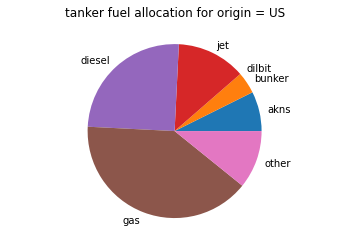

In [12]:
label = 'tanker'
US_tank = [ US[label]['akns']['total_gallons'], 
                US[label]['bunker']['total_gallons'], 
                US[label]['dilbit']['total_gallons'], 
                US[label]['jet']['total_gallons'], 
                US[label]['diesel']['total_gallons'], 
                US[label]['gas']['total_gallons'], 
                US[label]['other']['total_gallons']
               ]
plt.gca().axis("equal")
plt.pie(US_tank, labels= oil_types)
plt.title(f'{label} fuel allocation for origin = US')

Text(0.5, 1.0, 'atb fuel allocation for origin = US')

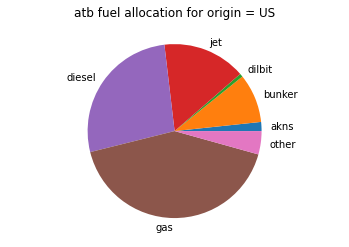

In [13]:
label = 'atb'
US_tank = [ US[label]['akns']['total_gallons'], 
                US[label]['bunker']['total_gallons'], 
                US[label]['dilbit']['total_gallons'], 
                US[label]['jet']['total_gallons'], 
                US[label]['diesel']['total_gallons'], 
                US[label]['gas']['total_gallons'], 
                US[label]['other']['total_gallons']
               ]
plt.gca().axis("equal")
plt.pie(US_tank, labels= oil_types)
plt.title(f'{label} fuel allocation for origin = US')

Text(0.5, 1.0, 'barge fuel allocation for origin = US')

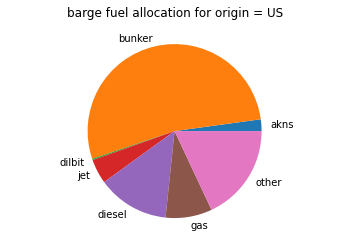

In [14]:
label = 'barge'
US_tank = [ US[label]['akns']['total_gallons'], 
                US[label]['bunker']['total_gallons'], 
                US[label]['dilbit']['total_gallons'], 
                US[label]['jet']['total_gallons'], 
                US[label]['diesel']['total_gallons'], 
                US[label]['gas']['total_gallons'], 
                US[label]['other']['total_gallons']
               ]
plt.gca().axis("equal")
plt.pie(US_tank, labels= oil_types)
plt.title(f'{label} fuel allocation for origin = US')

In [15]:
test = df.loc[
            (df.TransferType == 'Cargo') &
            (df.ReceiverTypeDescription.isin(['TANK BARGE','TUGBOAT'])) & 
            (~df.Receiver.str.contains('ITB')) & (~df.Receiver.str.contains('ATB')) &
            (df.Deliverer.isin(facility_names))
]
for receivers in test.Receiver:
    if ('ITB' in receivers) | ('ATB' in receivers):
        print('dang it!')